# PREDICTION OF COVERAGE OUTCOMES

###### This notebook builds a random forest model to predict iron fortification coverage in schools in India. It imports data from Stata, performs some basic cleaning, and builds two random forest models. Given the large number of features relative to the number of samples, it seemed likely that an RF on all features would overfit. After building a baseline model on all features, I examine feature importance and then train a new model on important features. As expected, the accuracy on the OOB sample increases substantially.

In [46]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn_pandas import DataFrameMapper
import random
import sklearn as sk
import scipy.stats as stats
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.model_selection import cross_val_score
from fastai.imports import *
from fastai.tabular import *
#from fastai.structured import *

#models
from sklearn import linear_model
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from statsmodels.regression.linear_model import OLS
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from mlens.ensemble import SuperLearner


#metrics
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

#tools
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import itertools as it
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

#plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import scipy as sp
from itertools import combinations
import time

from sklearn import preprocessing
%matplotlib inline

## Importing & cleaning data

In [55]:
#Imports dataset from Stata
def import_stata(outcome):
    outcome_df_t=pd.read_stata("/Users/ChristyL/Dropbox (IDinsight)/Evidence Action IFA/02_Evaluation Design/4. Coverage prediction/2. Data/data_clean/schools_training_"+outcome+"_clean.dta")
    
    #Saving school codes separately
    schoolid_outcome=outcome_df_t.loc[:,['SCHCD']]
    outcome_df=outcome_df_t.loc[:, outcome_df_t.columns != 'SCHCD']
    
    x = outcome_df.values[:, :-1]
    y = outcome_df.values[:, -1]
    y=y.astype('int')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=46)
    
    return outcome_df, schoolid_outcome, x_train, x_test, y_train, y_test

In [56]:
(tablets_df,tablets_id, x_train_tablets, x_test_tablets, y_train_tablets, y_test_tablets)=import_stata("tablets")

In [29]:
#Data processing code borrowed from fast.ai course
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
        
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):

    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return df, y


In [31]:
train_cats(tablets_df)
(tablets_x, tablets_y)=proc_df(tablets_df,'wifs_tablets_last_month',max_n_cat=11,do_scale=True)

In [32]:
tablets_x.head()

,fail1b,fail2b,fail3b,fail4b,fail5b,fail6b,fail7b,fail8b,fail9b,fail10b,...,wsec25p_any_nan,smcsdp_0,smcsdp_1,smcsdp_nan,txtbkrecd_0,txtbkrecd_1,txtbkrecd_nan,no_census_0,no_census_1,no_census_nan
0,-0.146461,-0.12535,-0.112095,-0.105405,-0.113175,-0.047272,-0.040858,-0.046805,-0.168322,-0.169207,...,0,0,1,0,0,1,0,0,1,0
1,-0.146461,-0.12535,-0.112095,-0.105405,-0.113175,-0.047272,-0.040858,-0.046805,-0.168322,-0.169207,...,0,0,1,0,0,1,0,0,1,0
2,-0.146461,-0.12535,-0.112095,-0.105405,-0.113175,-0.047272,-0.040858,-0.046805,-0.168322,-0.169207,...,0,0,1,0,0,1,0,0,1,0
3,-0.146461,-0.12535,-0.112095,-0.105405,-0.113175,-0.047272,-0.040858,-0.046805,-0.168322,-0.169207,...,0,0,1,0,0,1,0,0,1,0
4,-0.146461,-0.12535,-0.112095,-0.105405,-0.113175,-0.047272,-0.040858,-0.046805,-0.168322,-0.169207,...,0,1,0,0,0,1,0,0,1,0


## Building random forest classifiers

##### First build baseline RF classifier. Then identify important features and train new model.

In [49]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_features='log2', n_jobs=-1, oob_score=True)
m.fit(x_train_tablets, y_train_tablets)
print(m.oob_score_)

0.6465997770345596


In [50]:
fi = rf_feat_importance(m, tablets_df.loc[:, tablets_df.columns != 'wifs_tablets_last_month']); fi[:10]

,cols,imp
307,schooldays,0.016663
338,dist_name,0.015706
154,bookinlib,0.015031
255,tot_b,0.014201
24,workdays_pr,0.013890
68,estdyear,0.012899
257,boy_girl_ratio,0.012529
256,tot_g,0.012157
314,student_teacher_ratio,0.011861
281,gen_g,0.011192


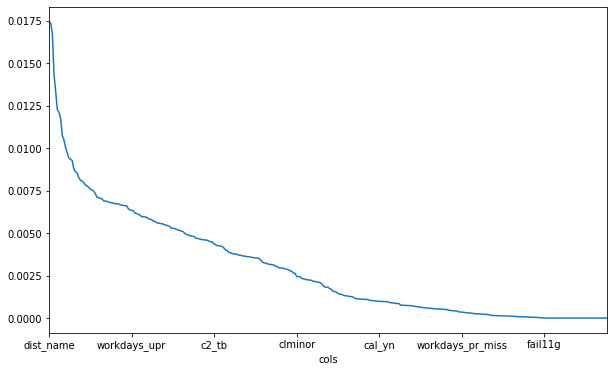

In [52]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [59]:
#Creating new dataframe with only important features
to_keep = fi[fi.imp>0.002].cols; len(to_keep)
df_tablets_keep = tablets_df[to_keep].copy()
x_tablets2 = df_tablets_keep.values[:, :-1]
y_tablets2 = df_tablets_keep.values[:, -1]
y_tablets2=y_tablets2.astype('int')
x_train_tab_small, x_test_tab_small, y_train_tab_small, y_test_tab_small = train_test_split(x_tablets2, y_tablets2, test_size=0.2, random_state=46)


In [66]:
#Training new RF on new dataframe. As expected, accuracy improves.
m_2 = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_features='log2', n_jobs=-1, oob_score=True)
m_2.fit(x_tablets2, y_tablets2)
print(m_2.oob_score_)
print(m_2.score(x_test_tab_small,y_test_tab_small))
y_probs = m_2.predict(x_test_tab_small)
confusion_matrix(y_test_tab_small,y_probs)

0.9754738015607581
0.9888888888888889


array([[ 76,   2],
       [  0, 102]])